In [1]:
from bisect import bisect_right
import os
import sys
import traceback

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

parent = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent not in sys.path:
    sys.path = [parent] + sys.path
import kradagrad
from kradagrad.third_party.resnet_cifar10.trainer import model_names, train, validate, save_checkpoint, AverageMeter, accuracy
mf = kradagrad.positive_matrix_functions

torch.cuda.set_device(0)

In [2]:
import argparse
import shutil

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as xforms
import torchvision.datasets as datasets

from kradagrad.third_party.resnet_cifar10 import resnet

def make_optimizer(params, args):
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(
            params, args.lr,
            weight_decay=args.weight_decay,
            momentum=args.momentum
        )
    elif args.optimizer == 'ada':
        optimizer = torch.optim.Adam(
            params, args.lr,
            weight_decay=args.weight_decay,
            eps=args.eps
        )
    elif args.optimizer in ['shampoo', 'kradmm', 'krad']:
        hps = kradagrad.HyperParams(
            matrix_eps=args.eps,  weight_decay=args.weight_decay, graft_type=0, beta2=1,            
            block_size=27 if args.arch in ['resnet32', 'resnet56'] else 125,
            inverse_exponent_override=args.inverse_exponent_override,
        )
        if args.optimizer == 'shampoo':
            optimizer = kradagrad.Shampoo(params, lr=args.lr, hyperparams=hps, momentum=args.momentum)
        elif args.optimizer == 'kradmm':
            optimizer = kradagrad.KradagradMM(params, lr=args.lr, hyperparams=hps, momentum=args.momentum, debug=args.debug)
        elif args.optimizer == 'krad':
            optimizer = kradagrad.KradagradPP(params, lr=args.lr, momentum=args.momentum, hyperparams=hps,
                                             tensor_batch_size=16)
    else:
        raise ValueError('unknown optimizer: {}'.format(args.optimizer))
    return optimizer

In [3]:

def train_run(args):
    best_prec1 = 0
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    writer = SummaryWriter(os.path.join(args.save_dir, 'tensorboard_{}{}'.format(args.optimizer, args.opt_modifier_str)))
    

    model = torch.nn.DataParallel(resnet.__dict__[args.arch]())
    model.cuda()

    # resume from a checkpoint    
    loss_s = []
    prec_s = []
    found = False
    final_path = os.path.join(args.save_dir, 'model_{}{}.th'.format(args.optimizer, args.opt_modifier_str))
    ckpt_path = os.path.join(args.save_dir, 'checkpoint_{}{}.th'.format(args.optimizer, args.opt_modifier_str))
    if os.path.isfile(final_path):
        fn = final_path
        found = True
    elif os.path.isfile(ckpt_path):
        fn = ckpt_path
        found = True
    else:
        found = False
    if found:
        print(" - found checkpoint '{}'".format(fn))
        checkpoint = torch.load(fn)
        args.start_epoch = checkpoint['epoch']
        loss_fn = os.path.join(args.save_dir, 'loss_{}{}.npy'.format(args.optimizer, args.opt_modifier_str))
        prec_fn = os.path.join(args.save_dir, 'prec_{}{}.npy'.format(args.optimizer, args.opt_modifier_str))
        loss_s = np.load(loss_fn)
        prec_s = np.load(prec_fn)        
        print("     loss '{}'".format(loss_fn))
        print("     prec '{}'".format(prec_fn))
        if args.start_epoch < args.epochs:
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print(" - loaded checkpoint (epoch {})".format(args.start_epoch))
            loss_s = list(loss_s)
            prec_s = list(prec_s)
        else:
            print(" - model done training")
            return loss_s, prec_s
    else:
        print(" - no checkpoint found in '{}'".format(args.save_dir))

    cudnn.benchmark = True

    normalize = xforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    xforms_tr = [xforms.RandomHorizontalFlip(), xforms.RandomCrop(32, 4), xforms.ToTensor(), normalize]

    dataset_to_use = datasets.CIFAR10 if args.data == 'CIFAR10' else datasets.CIFAR100 if args.data == 'CIFAR100' else None
    dataset_tr = dataset_to_use(root='./data', train=True, transform=xforms.Compose(xforms_tr), download=True)
    dataset_va = dataset_to_use(root='./data', train=False, transform=xforms.Compose([xforms.ToTensor(), normalize]))

    train_loader = torch.utils.data.DataLoader(dataset_tr, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(dataset_va, batch_size=128, shuffle=False, num_workers=args.workers, pin_memory=True)

    # define loss function (criterion)
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        model.half()
        criterion.half()

    ## choose optimizer
    optimizer = make_optimizer(model.parameters(), args)
    milestones = [100, 150]
    if args.optimizer in ['sgd', 'ada']:
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=milestones, last_epoch=args.start_epoch - 1
        )
    ## End optimizer setup
    
    
    if args.evaluate:
        loss_va, prec1_va = validate(val_loader, model, criterion)
        return loss_va, prec1_va

    for epoch in tqdm(range(args.start_epoch, args.epochs), 'Epoch', ncols=80):

        # train for one epoch
        loss_tr, prec1_tr = train(train_loader, model, criterion, optimizer, epoch, args)
        
        # evaluate on validation set
        loss_va, prec1_va = validate(val_loader, model, criterion, args)
        if args.optimizer in ['sgd', 'ada']:
            lr_scheduler.step()
        #elif args.optimizer in ['kradmm']:
        #    pow_ = bisect_right(milestones, epoch)
        #    for group in optimizer.param_groups:
        #        group['lr'] *= 0.1 ** pow_
        writer.add_scalar('loss/train', loss_tr, epoch)
        writer.add_scalar('loss/val', loss_va, epoch)
        
        writer.add_scalar('prec1/train', prec1_tr, epoch)
        writer.add_scalar('prec1/val', prec1_va, epoch)
        
        if args.optimizer in ['krad', 'kradmm', 'shampoo']:
            precon_norms = {str(i): mf.matrices_norm(precon).cpu().numpy() for i, precon in enumerate([precon_ for group_ in optimizer.param_groups for param_ in group_['params'] for precon_ in optimizer.state[param_]['preconditioner'].preconditioners])}
            writer.add_scalars('norms/precon', precon_norms, epoch)
            stat_norms = {str(i): mf.matrices_norm(stat).cpu().numpy() for i, stat in enumerate([stat_ for group_ in optimizer.param_groups for param_ in group_['params'] for stat_ in optimizer.state[param_]['preconditioner'].statistics])}
            writer.add_scalars('norms/stat', stat_norms, epoch)

        loss_s.append((loss_tr, loss_va))
        prec_s.append((prec1_tr, prec1_va))
        # remember best prec@1 and save checkpoint
        is_best = prec1_va > best_prec1
        best_prec1 = max(prec1_va, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
                'initial_lr': args.lr,
            }, is_best, filename=os.path.join(args.save_dir, 'checkpoint_{}{}.th'.format(args.optimizer, args.opt_modifier_str)))

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'initial_lr': args.lr,
        }, is_best, filename=os.path.join(args.save_dir, 'model_{}{}.th'.format(args.optimizer, args.opt_modifier_str)))
        np.save(os.path.join(args.save_dir, 'loss_{}{}.npy'.format(args.optimizer, args.opt_modifier_str)), np.array(loss_s))
        np.save(os.path.join(args.save_dir, 'prec_{}{}.npy'.format(args.optimizer, args.opt_modifier_str)), np.array(prec_s))
    return loss_s, prec_s

In [ ]:
arch = 'resnet32'
data = 'CIFAR10'

epochs = 10
epochs = 200

exp_name = 'epoch{}'.format(epochs)
#optimizer_s = ['sgd', 'ada', 'kradmm']
optimizer_s = ['sgd', 'shampoo', 'krad']
loss_s = {}
prec_s = {}
for optimizer_ in optimizer_s:
    eps_str = (
        '1e-4' if optimizer_ in ['krad', 'shampoo'] else
        '1e-4' if optimizer_ in ['kradmm'] else
        '1e-1'
    )
    lr_str = (
        '1e-1' if optimizer_ in ['sgd'] else
        '1e-1' if optimizer_ in ['krad', 'kradmm', 'shampoo'] else
        #'5e-1' if optimizer_ in ['kradmm'] else  # doesn't generalize well
        '5e-2'                                    # adam nan'd with 0.1
    ) # lower to prevent nan's
    args = argparse.Namespace(
        arch='resnet32',
        data=data,
        workers=4,
        optimizer=optimizer_,
        epochs=epochs,
        start_epoch=0,
        lr=eval(lr_str),
        momentum=0.9,
        weight_decay=0,
        eps=eval(eps_str),
        evaluate=False,
        pretrained=False,
        
        half=True,
        batch_size=1024,
        #half=optimizer_ in ['sgd', 'ada'],
        #batch_size=1024 if optimizer_ in ['sgd', 'ada'] else 256,
        
        save_dir='{}_{}_{}_ckpts'.format(arch, data, exp_name),
        save_every=5,
        
        #ONS:
        #inverse_exponent_override=1 if optimizer_ in ['krad', 'kradmm'] else 0,
        #adagrad:
        inverse_exponent_override=0,
        
        debug=False,
        #debug=True,
    )
    
    opt_modifier_str = (
        '_eps{}_lr{}_ONS{}_batch{}'.format(
            eps_str, lr_str, args.inverse_exponent_override, args.batch_size
        ) if optimizer_ in ['kradmm']
        else '_batch{}'.format(args.batch_size)
    )
    args.opt_modifier_str = opt_modifier_str 
    
    print("\n=> Training using optimizer '{}{}'".format(optimizer_, opt_modifier_str))
    
    # reproducible
    torch.manual_seed(4750)
    
    loss_, prec_ = train_run(args)
    
    loss_s[optimizer_] = loss_
    prec_s[optimizer_] = prec_



=> Training using optimizer 'sgd_batch1024'
 - found checkpoint 'resnet32_CIFAR10_epoch200_ckpts/model_sgd_batch1024.th'
     loss 'resnet32_CIFAR10_epoch200_ckpts/loss_sgd_batch1024.npy'
     prec 'resnet32_CIFAR10_epoch200_ckpts/prec_sgd_batch1024.npy'
 - model done training

=> Training using optimizer 'shampoo_batch1024'
 - found checkpoint 'resnet32_CIFAR10_epoch200_ckpts/model_shampoo_batch1024.th'
     loss 'resnet32_CIFAR10_epoch200_ckpts/loss_shampoo_batch1024.npy'
     prec 'resnet32_CIFAR10_epoch200_ckpts/prec_shampoo_batch1024.npy'
 - model done training

=> Training using optimizer 'krad_batch1024'
 - no checkpoint found in 'resnet32_CIFAR10_epoch200_ckpts'
Files already downloaded and verified


Epoch:   6%|█▊                               | 11/200 [04:38<1:18:58, 25.07s/it]

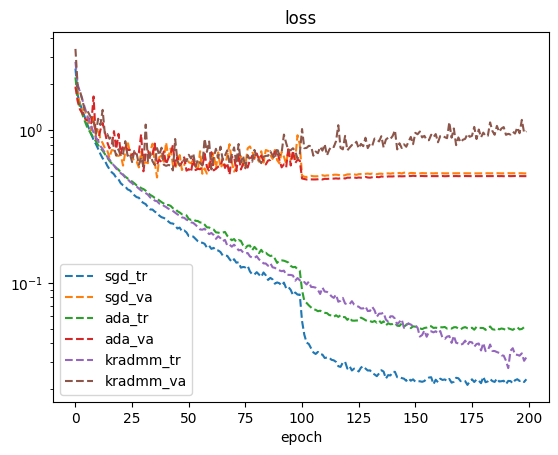

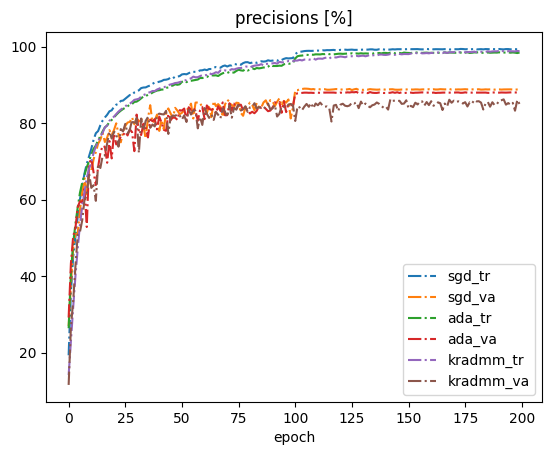

In [8]:
flatten = lambda z: [x for y in z for x in y]
#for opt_ in optimizer_s:
#    print(opt_, loss_s[opt_])
plt.figure()
for opt_name_ in optimizer_s:
    plt.semilogy(loss_s[opt_name_], '--')
plt.legend(flatten([
    ('{}_tr'.format(opt_), '{}_va'.format(opt_)) for opt_ in optimizer_s
]))
plt.xlabel('epoch')
plt.title('loss')


plt.figure()
for opt_name_ in optimizer_s:
    plt.plot(prec_s[opt_name_], '-.')
plt.legend(flatten([
    ('{}_tr'.format(opt_), '{}_va'.format(opt_)) for opt_ in optimizer_s
]))
plt.xlabel('epoch')
plt.title('precisions [%]')

plt.show()